In [36]:
import importlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Optional

import allib
from allib.models.al import ActiveLearningPipeline, RandomMetric, UncertainMetric
from allib.datasets import get_uci_db, load_uci, Dataset
from allib.metrics import get_metrics

from sklearn import preprocessing
from tqdm.notebook import tqdm 
from catboost import CatBoostClassifier, to_classifier, sum_models
importlib.reload(allib)

<module 'allib' from '/Users/jecosine/Courses/COMP8800/CatBoostPlayground/allib/__init__.py'>

In [37]:
# uniform sampling dataset
D = np.random.uniform(size=(10, 2))
n = 100
p1, p2 = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
p3 = np.maximum(1 - p1 - p2, 0)
unc = np.array([p1, p2, p3]).max(axis=0)

In [38]:
def model_factory(params: dict):
    def build_model():
        return CatBoostClassifier(
            **params
        )
    return build_model
model_params = {
    "iterations":5,
    "learning_rate":0.1,
    # "cat_features":cat_idx
    # "loss_function":'CrossEntropy'
}
make_model = model_factory(model_params)


In [39]:
class CatBoostPPL(ActiveLearningPipeline):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.extra_params = {
            "cat_features": kwargs.get("cat_idx")
        }
        
    
    def run(self, n_iter: Optional[int]=None, extra_params: dict={}):
        self.model = self.model_maker()
        counter = 0
        for tx, ty in self.dataset:
            if counter >= self.early_stop:
                break
            self.model.fit(tx, ty, verbose=False, **extra_params)
            self.apply_eval_metrics()
            counter += 1

In [40]:
uci_db = get_uci_db()
print(len(uci_db))

614


In [41]:
(data, label), _, cat_idx = load_uci("iris")

Temp file downloaded: /var/folders/sw/pst936gn6892f4b679px1_lc0000gn/T/tmphg7rgrof
Extracting /var/folders/sw/pst936gn6892f4b679px1_lc0000gn/T/tmphg7rgrof to /Users/jecosine/Courses/COMP8800/CatBoostPlayground/examples/dataset_cache/iris...


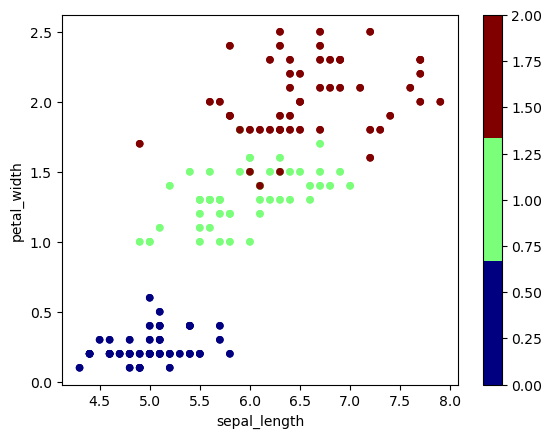

In [42]:
cmap = plt.get_cmap('jet', label.nunique())
sct = data.plot.scatter(x="sepal_length", y="petal_width", c = label.astype('category').cat.codes, cmap = cmap)

In [43]:
SEEDS = [i+10 for i in range(3)]
params = {
    "init_size": 20,
    "batch_size": 10
}
random_metric = RandomMetric(**params)
uncertain_metric = UncertainMetric(**params)
rand_dataset = Dataset(data, label, al_metric=random_metric, shuffle=False, **params)
uncert_dataset = Dataset(data, label, al_metric=uncertain_metric, shuffle=False, **params)
ppl_rand = CatBoostPPL(model=make_model(), model_maker=make_model, seeds=SEEDS, dataset=rand_dataset, eval_metrics=get_metrics(["accuracy"]), n_times=3)
ppl_uncert = CatBoostPPL(model=make_model(), model_maker=make_model, seeds=SEEDS, dataset=uncert_dataset, eval_metrics=get_metrics(["accuracy"]), n_times=3)

In [44]:
ppl_uncert.start()
ppl_rand.start()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [46]:
import pickle
with open(f"str_cache/iris_uncert_3.pkl", "wb") as f:
    pickle.dump(ppl_uncert.stats, f)
with open(f"str_cache/iris_rand_3.pkl", "wb") as f:
    pickle.dump(ppl_rand.stats, f)

In [47]:
def plot_query(stats, ds:Dataset):
    fig, axs = plt.subplots(1, 1+len(stats), sharey=True, figsize=(5 * (1 + len(stats)), 5))
    # plot cluster
    x = ds.u_x.copy()
    l = ds.u_y.copy().label.astype('category').cat.codes
    x1, x2 = x["sepal_length"], x["petal_width"]
    cmap = plt.get_cmap("jet", l.nunique())
    axs[0].scatter(x1, x2, c=l, cmap=cmap)
    for ax_idx, stat in enumerate(stats):
        ds.random_state = SEEDS[ax_idx]
        ds.reset()
        x = ds.u_x.copy()
        x["c"] = 0
        c = x.c.copy()
        x1, x2 = x["sepal_length"], x["petal_width"]
        snapshots = stat["snapshot"]
        cmap = plt.get_cmap("Oranges", len(snapshots))
        for idx, snap in enumerate(snapshots):
            c.loc[snap] = idx
        aa = axs[1+ax_idx].scatter(x1, x2, c=c, cmap=cmap)
    fig.colorbar(aa, ax=axs[:], location="right")
    # fig.tight_layout()

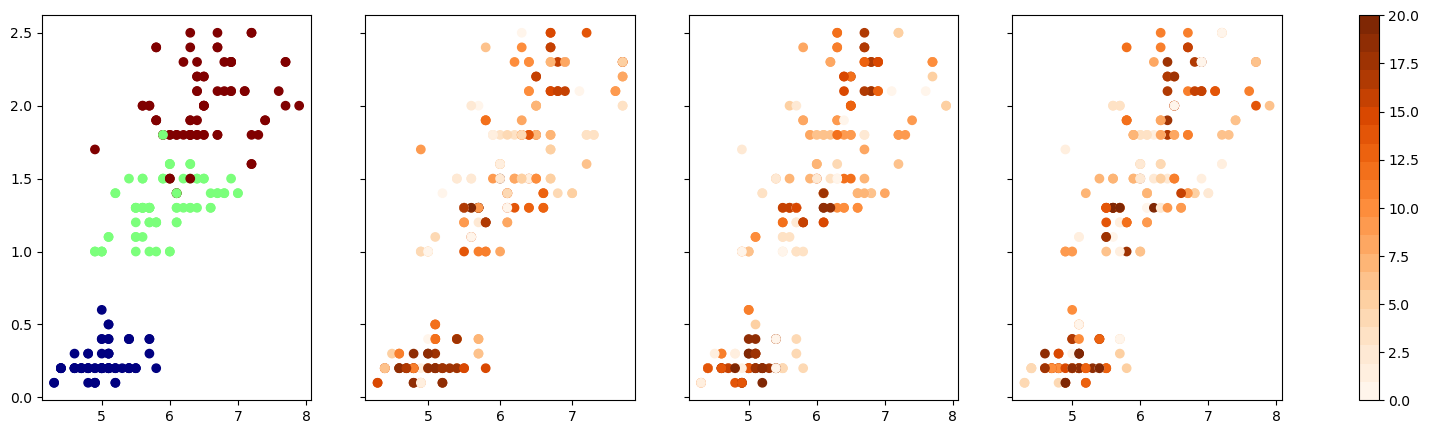

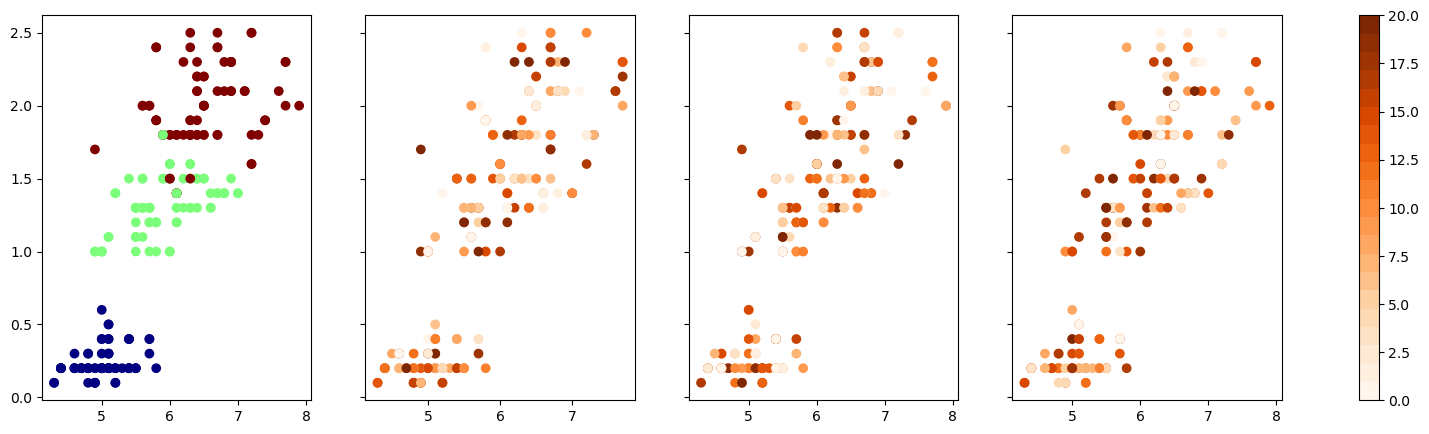

In [48]:
uncert_stats = ppl_uncert.stats
rand_stats = ppl_rand.stats
plot_query(uncert_stats, uncert_dataset)
plot_query(rand_stats, rand_dataset)

(1000, 2)


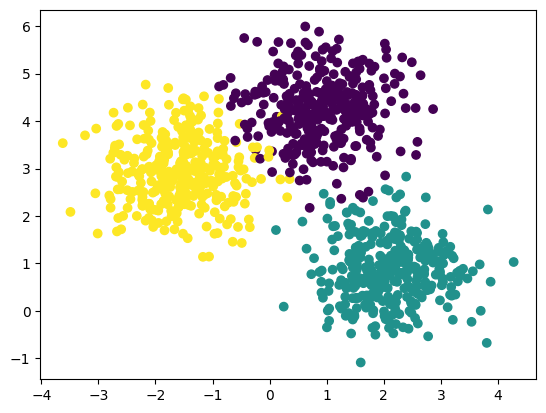

In [94]:
from sklearn.datasets import make_blobs
data, label = make_blobs(n_features=2, n_samples=1000, centers=3, random_state=0, cluster_std=0.7)
print(data.shape)
sct = plt.scatter(data[:,0], data[:,1], c=label)
SEEDS = [i + 10 for i in range(3)]
params = {
    "init_size": 5,
    "batch_size": 10
}
random_metric = RandomMetric(**params)
uncertain_metric = UncertainMetric(**params)
rand_dataset = Dataset(data, label, al_metric=random_metric, shuffle=False, **params)
uncert_dataset = Dataset(data, label, al_metric=uncertain_metric, shuffle=False, **params)
ppl_rand = CatBoostPPL(model=make_model(), model_maker=make_model, seeds=SEEDS, dataset=rand_dataset,
                       eval_metrics=get_metrics(["accuracy"]), n_times=3)
ppl_uncert = CatBoostPPL(model=make_model(), model_maker=make_model, seeds=SEEDS, dataset=uncert_dataset,
                         eval_metrics=get_metrics(["accuracy"]), n_times=3)

In [95]:
ppl_uncert.start()
ppl_rand.start()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [169]:
def plot_query(stats, ds:Dataset):
    fig, axs = plt.subplots(1, 1+len(stats), sharey=True, figsize=(5 * (1 + len(stats)), 5), dpi=100)
    # plot cluster
    x = ds.u_x.copy()
    l = ds.u_y.copy()
    x1, x2 = x[0], x[1]
    cmap = plt.get_cmap("jet", 3)
    axs[0].scatter(x1, x2, c=l, cmap=cmap)
    for ax_idx, stat in enumerate(stats):
        ds.random_state = SEEDS[ax_idx]
        ds.reset()
        x = ds.u_x.copy()
        x["c"] = 0
        c = x.c.copy()
        x1, x2 = x[0], x[1]
        snapshots = stat["snapshot"]
        cmap = plt.get_cmap("Oranges", len(snapshots))
        for idx, snap in enumerate(snapshots):
            c.loc[snap] = idx + 1
            # aa=axs[1+ax_idx].scatter(x1.loc[snap], x2.loc[snap], c=c.loc[snap], cmap=cmap, s=50)
        # print(c.value_counts())
        # break
        didx = c[c==0].index
        x1 = x1.drop(didx)
        x2 = x2.drop(didx)
        c = c.drop(didx)
        aa=axs[1+ax_idx].scatter(x1, x2, c=c, cmap=cmap, s=50)
    fig.colorbar(aa, ax=axs[:], location="right")


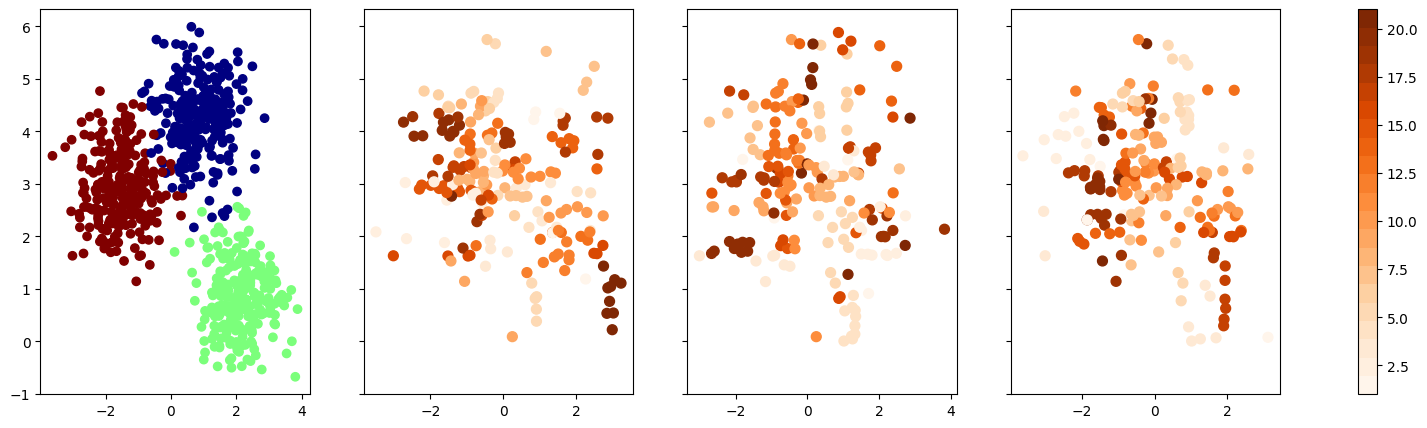

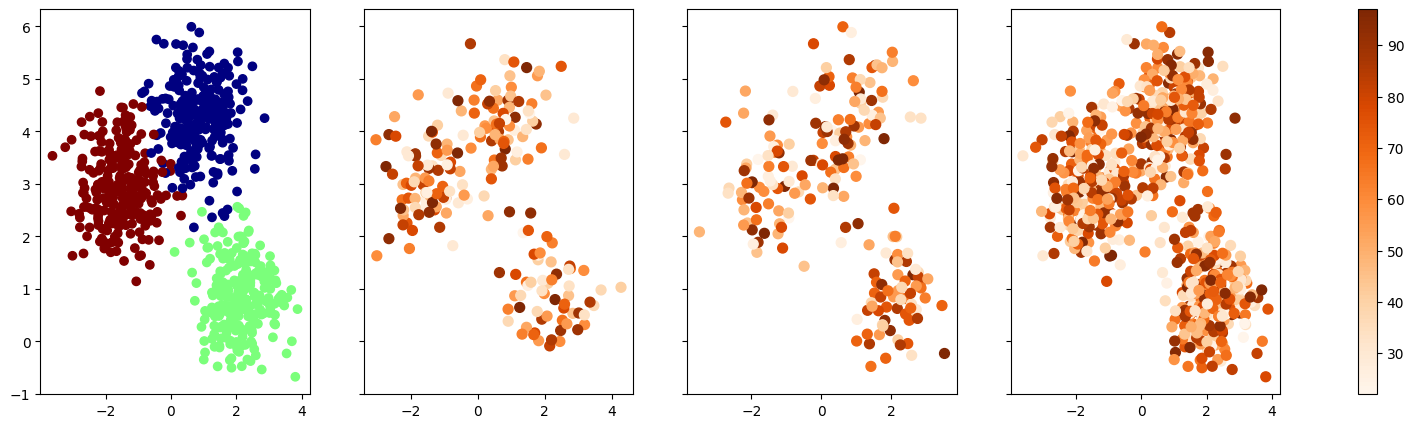

In [170]:
import pickle
with open(f"str_cache/blob_uncert_3.pkl", "wb") as f:
    pickle.dump(ppl_uncert.stats, f)
with open(f"str_cache/blob_rand_3.pkl", "wb") as f:
    pickle.dump(ppl_rand.stats, f)
uncert_stats = ppl_uncert.stats
rand_stats = ppl_rand.stats
plot_query(uncert_stats, uncert_dataset)
plot_query(rand_stats, rand_dataset)

In [143]:
rand_dataset.reset()
lds = [(x,y) for x, y in rand_dataset]

In [147]:
snps = [rand_stats[i]["snapshot"] for i in range(len(rand_stats))]

In [148]:
snps[0]

[Index([878, 231, 112, 683, 36], dtype='int64'),
 Index([833, 396, 515, 959, 864, 50, 674, 670, 909, 391], dtype='int64'),
 Index([690, 201, 432, 314, 775, 238, 639, 847, 767, 135], dtype='int64'),
 Index([348, 991, 283, 777, 725, 921, 885, 480, 546, 727], dtype='int64'),
 Index([745, 397, 494, 372, 962, 677, 404, 844, 561, 675], dtype='int64'),
 Index([526, 292, 279, 338, 459, 517, 838, 495, 368, 98], dtype='int64'),
 Index([781, 712, 756, 118, 72, 61, 931, 53, 571, 58], dtype='int64'),
 Index([761, 581, 388, 493, 377, 563, 822, 893, 595, 598], dtype='int64'),
 Index([698, 366, 236, 360, 331, 145, 623, 303, 447, 996], dtype='int64'),
 Index([856, 102, 134, 286, 554, 790, 383, 669, 832, 512], dtype='int64'),
 Index([578, 469, 583, 246, 59, 995, 577, 125, 710, 547], dtype='int64'),
 Index([849, 168, 740, 80, 963, 214, 234, 928, 130, 997], dtype='int64'),
 Index([852, 666, 541, 803, 9, 253, 129, 269, 26, 157], dtype='int64'),
 Index([938, 209, 902, 243, 106, 662, 414, 850, 373, 25], dtyp

In [146]:
[len(lds[i][0]) for i in range(len(lds))]

[5,
 15,
 25,
 35,
 45,
 55,
 65,
 75,
 85,
 95,
 105,
 115,
 125,
 135,
 145,
 155,
 165,
 175,
 185,
 195,
 205,
 215,
 225,
 235,
 245,
 255,
 265,
 275,
 285,
 295,
 305,
 315,
 325,
 335,
 345,
 355,
 365,
 375,
 385,
 395,
 405,
 415,
 425,
 435,
 445,
 455,
 465,
 475,
 485,
 495,
 505,
 515,
 525,
 535,
 545,
 555,
 565,
 575,
 585,
 595,
 605,
 615,
 625,
 635,
 645,
 655,
 665,
 675,
 685,
 695,
 705,
 715,
 725,
 735,
 745,
 750]

In [6]:
import re

In [26]:
s = "asda_01"
pattern = re.compile(r"asda_(\\d+)")

In [29]:
res = re.match(r"asda_(\d*)", s)

In [35]:
res.groups()

('01',)